In [1]:
import pandas as pd
import pandas_profiling

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb


#データ読み込み
train = pd.read_csv("data/train_df.csv")
test = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

train.describe()

## データ修正

In [2]:
#データ読み込み
train = pd.read_csv("data/train_df.csv")
test = pd.read_csv("data/test_df.csv")
sample= pd.read_csv("data/submission.csv",header = None)

In [3]:
pd.options.display.max_columns = 100
random_state = 123
# train = train[:10000]
# test = test[:3000]
# train.info()

In [4]:
#カテゴリと考えられる変数を変更
train['id'] = train['id'].astype(object)
train['personal_id_1'] = train['personal_id_1'].astype(object)
train['personal_id_2'] = train['personal_id_2'].astype(object)                  
train['facility_id'] = train['facility_id'].astype(object) 
train['icu_5'] = train['icu_5'].astype(object)
train['icu_id'] = train['icu_id'].astype(object)

In [5]:
# 数値データ
x_train=train.drop('target_label',axis=1)
col_num = x_train.columns[x_train.dtypes!='object'].values.tolist()
print('数値データ')
print(col_num)
col_cat = x_train.columns[x_train.dtypes=='object'].values.tolist()
print('カテゴリ変数')
print(col_cat)

数値データ
['age', 'bmi', 'situation_1', 'situation_2', 'height', 'weight', 'icu_4', 'icu_6', 'icu_7', 'icu_8', 'glasgow_coma_scale_1', 'glasgow_coma_scale_2', 'glasgow_coma_scale_3', 'glasgow_coma_scale_4', 'heart_rate', 'blood_oxy', 'arterial_pressure', 'respiratory_rate', 'temp', 'blood_pressure_1', 'blood_pressure_2', 'blood_pressure_3', 'blood_pressure_4', 'v1_heartrate_max', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16', 'w17', 'w18', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'aids', 'cirrhosis', 'diabetes', 'hepatic_issue', 'immunosuppression', 'leukemia', 'lymphoma', 'carcinoma']
カテゴリ変数
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'ethnicity', 'gender', 'icu_id', 'icu_1', 'icu_2', 'icu_3', 'icu_5', 'body_system_1', 'body_system_2']


In [6]:
"""
エンコーディングの方針
nunique が比較的少ない変数はLabel Encoding
nunique が多い変数はCount EncodingとTarget Encodingの併用
"""

low_cat_cols = [] # nunique が比較的少ない変数
high_cat_cols = [] # nunique が多い変数

for c in col_cat:
    nunq = x_train[c].nunique()
    if nunq>48:
        high_cat_cols.append(c)
    else:
        low_cat_cols.append(c)
        
body_systems = ['body_system_1', 'body_system_2']
for r in body_systems:
    low_cat_cols.remove(r)
        
print('-'*20, 'unique_low', '-'*20)
print(low_cat_cols)
print('-'*20, 'unique_high', '-'*20)
print(high_cat_cols)

print('-'*20, 'body_systems', '-'*20)
print(body_systems)

-------------------- unique_low --------------------
['ethnicity', 'gender', 'icu_1', 'icu_2', 'icu_3', 'icu_5']
-------------------- unique_high --------------------
['id', 'personal_id_1', 'personal_id_2', 'facility_id', 'icu_id']
-------------------- body_systems --------------------
['body_system_1', 'body_system_2']


In [7]:
#少ない要素は確認してみる
for c in low_cat_cols:
    print(f"{c}:\t{x_train[c].unique()}")

ethnicity:	['Caucasian' 'African American' 'Other/Unknown' 'Hispanic' nan 'Asian'
 'Native American']
gender:	['M' 'F' nan]
icu_1:	['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_2:	['admit' 'readmit' 'transfer']
icu_3:	['MICU' 'CCU-CTICU' 'Med-Surg ICU' 'Neuro ICU' 'CSICU' 'SICU' 'CTICU'
 'Cardiac ICU']
icu_5:	[302.0 nan 304.0 123.0 114.0 305.0 301.0 122.0 119.0 308.0 113.0 118.0
 124.0 104.0 303.0 112.0 109.0 117.0 209.0 214.0 121.0 202.0 212.0 110.0
 101.0 116.0 217.0 102.0 115.0 203.0 105.0 103.0 108.0 307.0 213.0 120.0
 106.0 216.0 306.0 107.0 207.0 215.0 218.0 219.0 208.0]


In [8]:
#nunique が比較的少ない変数はLabel Encoding
#body_system1,2は同様のカラムだと考えohe

dict_low_cat = {}
for col in low_cat_cols:
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(x_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    # print(list_label)
    map_label = {j:i for i,j in enumerate(list_label)}
    train[col] = train[col].map(map_label)
    
    dict_low_cat[col] = {}
    dict_low_cat[col]['fillna'] = value_fillna
    dict_low_cat[col]['map_label'] = map_label
    dict_low_cat[col]['num_label'] = len(list_label)

print('Done')

ethnicity
gender
icu_1
icu_2
icu_3
icu_5
Done


In [9]:
# nunique が多い変数はCount EncodingとTarget Encodingの併用
# クロスバリデーション内で行う

# Count Encoding用
ids = ['id', 'personal_id_1', 'personal_id_2']
for i in ids:
    high_cat_cols.remove(i)
    
dict_high_cat = {}
for col in high_cat_cols :
    print(col)
    value_fillna = 'unknown'
    x_train[col] = x_train[col].fillna(value_fillna)
    x_train[col] = x_train[col].astype(str)
    
    map_count = x_train[col].value_counts().to_dict()
    x_train['CE_' + col] = x_train[col].map(map_count)
    
    dict_high_cat[col] = {}
    dict_high_cat[col]['fillna'] = value_fillna
    dict_high_cat[col]['map_count'] = map_count
    # dict_high_cat[col]['num_label'] = len(list_label)
    
    
print('Done')

facility_id
icu_id
Done


In [10]:
# 数値データは標準化
dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    x_train[col] = x_train[col].fillna(value_fillna)
    # 正規化
    value_min = x_train[col].min()
    value_max = x_train[col].max()
    value_mean = x_train[col].mean()
    value_std = x_train[col].std()
    train[col] = (x_train[col] - value_min) / (value_max - value_min)
    # X_tarin[col] = (X_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_max    
    dict_num[col]['std'] = value_max    
    
print('Done')

age
bmi
situation_1
situation_2
height
weight
icu_4
icu_6
icu_7
icu_8
glasgow_coma_scale_1
glasgow_coma_scale_2
glasgow_coma_scale_3
glasgow_coma_scale_4
heart_rate
blood_oxy
arterial_pressure
respiratory_rate
temp
blood_pressure_1
blood_pressure_2
blood_pressure_3
blood_pressure_4
v1_heartrate_max
v2
v3
v4
v5
v6
v7
v8
v9
v10
v11
v12
v13
v14
v15
v16
w1
w2
w3
w4
w5
w6
w7
w8
w9
w10
w11
w12
w13
w14
w15
w16
w17
w18
x1
x2
x3
x4
x5
x6
aids
cirrhosis
diabetes
hepatic_issue
immunosuppression
leukemia
lymphoma
carcinoma
Done


In [11]:
def transform_data(input_x):
    output_x = input_x.copy()
    
    for col in col_num:
        value_fillna = dict_num[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        value_min = dict_num[col]['min']
        value_max = dict_num[col]['max']
        output_x[col]  = (output_x[col] - value_min ) / (value_max - value_min)
        
    for col in low_cat_cols:
        value_fillna = dict_low_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_label = dict_low_cat[col]['map_label']#辞書からlabelencordの辞書を取り出す
        output_x[col] = output_x[col].map(map_label)
        
        #対応するものがない場合はunkoumn
        output_x[col] = output_x[col].fillna(map_label['unknown'])
        
    for col in high_cat_cols:
        value_fillna = dict_high_cat[col]['fillna']
        output_x[col] = output_x[col].fillna(value_fillna)
        
        output_x[col] = output_x[col].astype(str)
        
        map_count = dict_high_cat[col]['map_count']#辞書からcountencodeの辞書を取り出す
        output_x['CE_' + col] = output_x[col].map(map_count)
        
        
    return output_x

x_test = transform_data(test)

In [15]:
#body_sytemsとhigh_cat_cols（target_encord)以外修正後
#データを統合しbody_sytemsをone_hotencoding

# OHEのため全データ合算
concat_df = pd.concat([x_train, x_test], sort=False, ignore_index = True)


#病名のみのdf
train_body=concat_df[['body_system_1','body_system_2']]
#被っているものはbody_system_2をNanに
train_body['body_system_2'] = train_body['body_system_2'].where(
    train_body['body_system_1'] != train_body['body_system_2'])
#Nanはunknoun
train_body.fillna('unknown', inplace=True)

train_body['body_system_2'] = train_body['body_system_2'].replace('Undefined diagnoses', 'Undefined Diagnoses')
print(train_body.shape, concat_df.shape)

print(train_body['body_system_1'].unique())
print(train_body['body_system_2'].unique())
# ohe実行
ohe_body = pd.get_dummies(train_body.stack(), dummy_na=False, prefix='ohe').groupby(level=0).sum()

(64199, 2) (64199, 86)
['Cardiovascular' 'unknown' 'Gastrointestinal' 'Metabolic' 'Genitourinary'
 'Neurological' 'Trauma' 'Sepsis' 'Respiratory' 'Musculoskeletal/Skin'
 'Gynecological' 'Hematological']
['unknown' 'Renal/Genitourinary' 'Neurologic' 'Undefined Diagnoses'
 'Cardiovascular' 'Haematologic']


In [17]:
ohe_concat_df = pd.concat([concat_df, ohe_body], axis=1)#元の全体のDFに病歴のOHEをつなげる
ohe_concat_df = ohe_concat_df.drop(['body_system_1','body_system_2','ohe_unknown'], axis=1)
# 学習とテストに分解
n_train = ohe_concat_df[:len(x_train)]
n_train = pd.concat([n_train, train['target_label']], axis=1)
y_train = train[['target_label']]

n_test = ohe_concat_df[len(x_train):].reset_index(drop=True)

# Target Encoding用のラベル付きのDataFrameを用意
te_base_train = n_train[['facility_id', 'icu_id', 'target_label']].copy()
te_base_test = n_test[['facility_id', 'icu_id']].copy()

n_train.drop('target_label', axis=1, inplace=True)


print('学習用データ: {},   学習ラベル：{},  テストデータ：{}'.format(
    n_train.shape, y_train.shape, n_test.shape))
print('taget_encord用学習データ：{},  target_encord用テストデータ：{}'.format(
      te_base_train.shape, te_base_test.shape))

print('陽性ラベルの割合: {}％'.format(
    y_train.value_counts()[1] * 100 / len(n_train)))

学習用データ: (51359, 99),   学習ラベル：(51359, 1),  テストデータ：(12840, 99)
taget_encord用学習データ：(51359, 3),  target_encord用テストデータ：(12840, 2)
陽性ラベルの割合: 8.629451508012227％


In [21]:
n_test

,id,personal_id_1,personal_id_2,facility_id,age,bmi,situation_1,situation_2,ethnicity,gender,height,weight,icu_id,icu_1,icu_2,icu_3,icu_4,icu_5,icu_6,icu_7,icu_8,glasgow_coma_scale_1,glasgow_coma_scale_2,glasgow_coma_scale_3,glasgow_coma_scale_4,heart_rate,blood_oxy,arterial_pressure,respiratory_rate,temp,blood_pressure_1,blood_pressure_2,blood_pressure_3,blood_pressure_4,v1_heartrate_max,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,x1,x2,x3,x4,x5,x6,aids,cirrhosis,diabetes,hepatic_issue,immunosuppression,leukemia,lymphoma,carcinoma,CE_facility_id,CE_icu_id,ohe_Cardiovascular,ohe_Gastrointestinal,ohe_Genitourinary,ohe_Gynecological,ohe_Haematologic,ohe_Hematological,ohe_Metabolic,ohe_Musculoskeletal/Skin,ohe_Neurologic,ohe_Neurological,ohe_Renal/Genitourinary,ohe_Respiratory,ohe_Sepsis,ohe_Trauma,ohe_Undefined Diagnoses
0,51359,12058,66446,83,0.415730,0.000000,0.0,0.0,2,1,0.935119,0.000000,95,1,1,5,0.084908,11,0.227628,0.0,0.0,1.00,1.000000,0.0,1.0,0.691011,0.0,0.380,0.066667,0.931990,0.448485,0.622222,0.448485,0.622222,0.677966,0.677632,0.505435,0.660714,0.513812,0.660714,0.206522,0.06,0.99,0.90,0.547414,0.66250,0.547414,0.66250,0.934837,0.976190,0.454545,0.530973,0.451389,0.526316,0.682927,0.722222,0.509091,0.608696,0.515337,0.608696,0.322034,0.124031,0.99,0.92,0.515695,0.572165,0.515695,0.569231,0.261866,0.423611,0.500000,0.603448,0.000000,0.522843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,451,451.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,51360,92348,32311,185,0.674157,0.486054,1.0,0.0,2,1,0.947901,0.609140,679,2,0,6,0.082040,44,0.000114,0.0,0.0,0.75,1.000000,0.0,0.8,0.337079,0.0,0.755,0.083333,0.937028,0.515152,0.900000,0.515152,0.900000,0.468927,0.447368,0.717391,0.955357,0.729282,0.955357,0.152174,0.11,0.97,0.92,0.823276,0.91250,0.823276,0.91250,0.937343,0.984127,0.594406,0.752212,0.590278,0.745614,0.414634,0.472222,0.800000,0.956522,0.809816,0.956522,0.186441,0.085271,0.97,0.97,0.856502,0.984536,0.856502,0.979487,0.423895,0.638889,0.628571,0.758621,0.530303,0.512690,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1000,136.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,51361,68371,20639,157,0.786517,0.284538,0.0,1.0,2,1,0.909044,0.327957,697,1,0,7,0.085338,38,0.095904,0.0,0.0,0.75,0.833333,0.0,0.2,0.595506,0.0,0.290,0.650000,0.919395,0.472727,0.566667,0.472727,0.566667,0.491525,0.453947,0.532609,0.651786,0.541436,0.651786,0.217391,0.14,1.00,1.00,0.547414,0.64375,0.547414,0.64375,0.917293,0.965608,0.545455,0.690265,0.541667,0.684211,0.530488,0.604167,0.593939,0.710145,0.601227,0.710145,0.237288,0.108527,1.00,1.00,0.569507,0.654639,0.569507,0.651282,0.184943,0.322917,0.585714,0.706897,0.570707,0.538071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,751,350.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,51362,19544,116026,60,0.606742,0.411424,0.0,1.0,2,1,0.921826,0.487634,538,0,0,5,0.080686,20,0.319407,0.0,0.0,1.00,1.000000,0.0,0.8,0.662921,0.0,0.945,0.883333,0.000000,0.872727,0.811111,0.872727,0.811111,0.666667,0.388158,1.000000,0.723214,1.000000,0.723214,0.576087,0.00,1.00,0.94,1.000000,0.63125,1.000000,0.63125,0.879699,0.912698,0.783217,0.840708,0.777778,0.833333,0.621951,0.611111,0.824242,0.840580,0.834356,0.840580,0.491525,0.116279,0.98,0.97,0.820628,0.804124,0.820628,0.800000,0.165303,0.350694,0.528571,0.637931,0.520202,0.517766,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,320,320.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,51363,85588,102404,196,0.955056,0.581200,0.0,1.0,2,0,0.818038,0.542473,809,0,0,1,0.079871,15,0.048163,0.0,0.0,1.00,1.000000,0.0,1.0,0.926966,0.0,0.315,0.616667,0.924433,0.509091,0.577778,0.509091,0.577778,0.920904,0.750000,0.494565,0.562500,0.502762,0.562500,0.347826,0.18,0.98,0.89,0.512931,0.56250,0.512931,0.56250,0.929825,0.970899,0.461538,0.584071,0.458333,0.578947,0.975610,1.000000,0.466667,0.557971,0.472393,0.557971,0.457627,0.209302,0.96,0.96,0.533632,0.613402,0.533632,0.610256,0.180033,0.381944,0.557143,0.672414,0.580808,0.543147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1486,396.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,.

In [22]:
def tranform_data_TE(cat_cols, input_x, train_label):#catslist, testdata(df), labels(series) =>df
    output_x = input_x.copy()
    
    for c in cat_cols :
        data_tmp = pd.DataFrame({c: input_x[c], 'target': train_label})
        target_mean = data_tmp.groupby(c)['target'].mean()
        output_x.loc[:, c] = input_x[c].map(target_mean)
        
    return  output_x


cat_cols = ['facility_id', 'icu_id']
x_test = tranform_data_TE(cat_cols, n_test, y_train['target_label'])

In [23]:
def target_encoding(cat_cols, tr_x, tr_y, va_x):#list_cat df*3 => df*2
    # クロスバリデーションの中で実行し、出力されたデータでモデル学習する
    for c in cat_cols:
        # 学習データ全体で各カテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({c: tr_x[c], 'target': tr_y['target_label']})
        target_mean = data_tmp.groupby(c)['target'].mean()
        # バリデーションデータのカテゴリを置換
        va_x.loc[:, c] = va_x[c].map(target_mean)

        # 学習データの変換後の値を格納する配列を準備
        tmp = np.repeat(np.nan, tr_x.shape[0])
        
        cv_encoding = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=123).split(tr_x,tr_y['target_label']))
        for  nfold in list_nfold:
            idx_1, idx_2 = cv_encoding[nfold][0], cv_encoding[nfold][1]
            # out-of-foldで各カテゴリにおける目的変数の平均を計算
            target_mean = data_tmp.iloc[idx_1].groupby(c)['target'].mean()
            # 変換後の値を一時配列に格納
            tmp[idx_2] = tr_x[c].iloc[idx_2].map(target_mean)
        
        tr_x.loc[:, c] = tmp
        
    return tr_x, va_x

In [24]:
# カテゴリカル変数（ラベルエンコードとワンホットエンコードした特徴量）
# low_cat_colsは0,1、idsは三つのID、そのほかはOHEの出力0,1
cat_feats = low_cat_cols + ids + [c for c in n_train.columns if c.startswith('ohe_')]
for cat in cat_feats:
    # Category型に変換
    n_train[cat] = n_train[cat].astype('category')
    n_test[cat] = n_test[cat].astype('category')
    

N_FOLDS = 5
list_nfold=[0,1,2,3,4]
oof = np.zeros(len(n_train))
pred = np.zeros(len(n_test))
fi_df = pd.DataFrame()


# 必要に応じてencodeされた特徴量を保存し、あとで読み込めるようにしておく

# LightGBMのモデルの定義
random_state = 123
params = {
    'boosting_type' :'gbdt',
    'objective' : 'binary',
    'metrics' : 'auc',
    'learning_rate' : 0.1,
    'num_leaves': 48,
    'min_data_in_leaf': 126,
    'min_sum_hessian_in_leaf': 6.972104745468846e-05,
    'feature_fraction': 0.591372148877871,
    'bagging_fraction': 0.8492100478235491,
    'reg_alpha': 1.196667720289308,
    'reg_lambda': 0.10114064587525043,
    'random_state' : random_state,
    'importance_type' : 'gain'
    }


In [25]:
cv = list(StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(n_train, y_train ))
input_x= n_train
input_y= y_train
for  nfold in list_nfold :
    print('-'*20, nfold, '-'*20)
    # 変数をループしてtarget encoding
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
    x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
    x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
    
    
    print(x_tr.shape, y_tr.shape)
    print(x_va.shape, y_va.shape)
    print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['target_label'].mean(), y_tr['target_label'].mean(), y_va['target_label'].mean(),))
 
    
    model = lgb.LGBMClassifier(**params)
    model.fit(x_tr,
              y_tr,
              eval_set=[(x_tr,y_tr),(x_va,y_va)],
              early_stopping_rounds=100,
              verbose=100,
             )

-------------------- 0 --------------------
(41087, 99) (41087, 1)
(10272, 99) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.972104745468846e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.972104745468846e-05
[LightGBM] [Warning] bagging_fraction is set=0.8492100478235491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492100478235491
[LightGBM] [Warning] feature_fraction is set=0.591372148877871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.591372148877871
[100]	training's auc: 0.977091	valid_1's auc: 0.894285
-------------------- 1 --------------------
(41087, 99) (41087, 1)
(10272, 99) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[100]	training's auc: 0.977091	valid_1's auc: 0.887303
-------------------- 2 --------------

In [26]:
# cvでの評価用 iuput_yはsereis
def train_lgb(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
    print(input_x.shape)
    print(input_y.shape)
    
            
    cv = list(StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(n_train, y_train ))
    for  nfold in list_nfold :
        print('-'*20, nfold, '-'*20)
        # 変数をループしてtarget encoding
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        x_tr, x_va = target_encoding(cat_cols, x_tr, y_tr, x_va)
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
          format(y_train['target_label'].mean(), y_tr['target_label'].mean(), y_va['target_label'].mean(),))


        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr),(x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=100,
                 )
        # モデルの保存
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5,1,0).astype(int))
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5,1,0).astype(int))
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        _imp = pd.DataFrame({'col':input_x.columns, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        accuracy_score(input_y, np.where(train_oof>=0.5,1,0))))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
    # imp出力
    imp = imp.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [27]:
id_train = n_train[['id']]
n_train = n_train.drop(['id'], axis=1)

In [28]:
train_oof, imp, metrics = train_lgb(n_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

(51359, 98)
(51359, 1)
-------------------- 0 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[100]	training's auc: 0.977352	valid_1's auc: 0.896445
[accuracy] tr: 0.96, va: 0.930393
-------------------- 1 --------------------
(41087, 98) (41087, 1)
(10272, 98) (10272, 1)
y_train:0.086, y_tr:0.086, y_va0.086
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.972104745468846e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.972104745468846e-05
[LightGBM] [Warning] bagging_fraction is set=0.8492100478235491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492100478235491
[LightGBM] [Warning] feature_fraction is set=0.591372148877871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.591372148877871
[100]	training's auc: 0.977401	vali

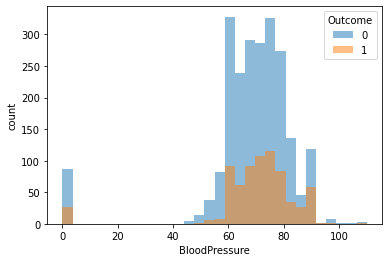

In [153]:
#　血圧との関係
plt.hist(train.loc[train['Outcome'] == 0, 'BloodPressure'].dropna(),
         bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Outcome'] == 1, 'BloodPressure'].dropna(),
         bins=30, alpha=0.5, label='1')
plt.xlabel('BloodPressure')
plt.ylabel('count')
plt.legend(title='Outcome')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   int64  
 10  BloodPressure_new         2887 non-null   float64
dtypes: float64(3), int64(8)
memory usage: 257.9 KB
70.97859744990893
72.88277858176556
71.43436092829927
87
26


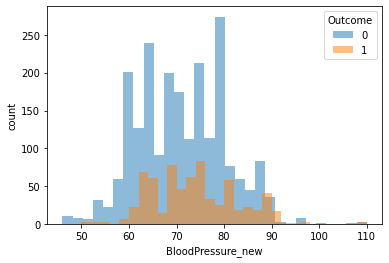

In [154]:
train['BloodPressure_new'] = train['BloodPressure'].replace([0], np.nan)
plt.hist(train.loc[train['Outcome'] == 0, 'BloodPressure_new'].dropna(),
         bins=30, alpha=0.5, label='0')
plt.hist(train.loc[train['Outcome'] == 1, 'BloodPressure_new'].dropna(),
         bins=30, alpha=0.5, label='1')
plt.xlabel('BloodPressure_new')
plt.ylabel('count')
plt.legend(title='Outcome')

train.info()
BPmean_0= train.loc[train['Outcome'] == 0, 'BloodPressure_new'].mean()
print(BPmean_0)
BPmean_1= train.loc[train['Outcome'] == 1, 'BloodPressure_new'].mean()
print(BPmean_1)
BPmean= train['BloodPressure_new'].mean()
print(BPmean)

print(train[train['Outcome']==0]['BloodPressure_new'].isnull().sum(axis=0))
print(train[train['Outcome']==1]['BloodPressure_new'].isnull().sum(axis=0))

血圧0は欠損、欠損かどうかの特徴量作成(0なら1、取得された値があれば1)

## 欠損処理関数

train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample= pd.read_csv("data/sample_submit.csv",header = None)

In [195]:
#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'Pregnancies_bin'
                ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [196]:
# 数値データ
col_num = X_train.columns[X_train.dtypes!='object'].values.tolist()

dict_num = {}
for col in col_num:
    print(col)
    # 欠損値を0へ
    value_fillna = 0 
    X_train[col] = X_train[col].fillna(value_fillna)
    # 正規化
    value_min = X_train[col].min()
    value_max = X_train[col].max()
    value_mean = X_train[col].mean()
    value_std = X_train[col].std()
    X_train[col] = (X_train[col] - value_min) / (value_max - value_min)
    # X_tarin[col] = (X_train[col] - value_mean) / value_std
    
    dict_num[col] = {}
    dict_num[col]['fillna'] = value_fillna
    dict_num[col]['min'] = value_min
    dict_num[col]['max'] = value_max
    dict_num[col]['mean'] = value_max    
    dict_num[col]['std'] = value_max    
    
print('Done')

DiabetesPedigreeFunction
BMI
Glucose
Age
Pregnancies
Done


In [197]:
# カテゴリデータ
# （embedding予定でラベルエンコーダー）
from sklearn.preprocessing import LabelEncoder
col_cat = X_train.columns[X_train.dtypes=='object'].values.tolist()

dict_cat = {}
for col in col_cat:
    print(col)
    value_fillna = 'unknown'
    X_train[col] = X_train[col].fillna(value_fillna)
    
    X_train[col] = X_train[col].astype(str)
    # strに変換
    le = LabelEncoder()
    le.fit(X_train[col])
    list_label = sorted(list(set(le.classes_) | set(['unknown'])))
    map_label = {j:i for i,j in enumerate(list_label)}
    X_train[col] = X_train[col].map(map_label)
    
    dict_cat[col] = {}
    dict_cat[col]['fillna'] = value_fillna
    dict_cat[col]['map_label'] = map_label
    dict_cat[col]['num_label'] = len(list_label)

print('Done')


Pregnancies_bin
Done


In [199]:
X_test

,DiabetesPedigreeFunction,BMI,Glucose,Age,Pregnancies,Pregnancies_bin
0,0.313823,0.708574,0.496403,0.000000,0.000000,2
1,0.027125,0.702316,0.223022,0.021739,0.230769,1
2,0.173992,0.557487,0.410072,0.000000,0.230769,1
3,0.166544,0.419302,0.640288,0.369565,0.076923,0
4,0.303618,0.712381,0.474820,0.152174,0.076923,0
...,...,...,...,...,...,...
1995,0.013546,0.693011,0.669065,0.108696,0.307692,1
1996,0.168592,0.676110,0.690647,0.152174,0.461538,3
1997,0.270176,0.962270,0.352518,0.173913,0.538462,3
1998,0.079172,0.712423,0.316547,0.108696,0.153846,0


In [200]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DiabetesPedigreeFunction  3000 non-null   float64
 1   BMI                       3000 non-null   float64
 2   Glucose                   3000 non-null   float64
 3   Age                       3000 non-null   float64
 4   Pregnancies               3000 non-null   float64
 5   Pregnancies_bin           3000 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 140.8 KB


In [173]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(X_train['Pregnancies_bin'].values.reshape(-1, 1))
list_ohe_label = sorted(list(set(le.classes_) | set(['unknown'])))
map_ohe_label = {j:i for i,j in enumerate(list_label)}

map_label

{'-1': 0, '-3': 1, '0': 2, '3-': 3, 'unknown': 4}